In [23]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats
from operator import attrgetter
from math import sqrt, pi
import matplotlib.pyplot as plt

## This notebook is a preliminary exploration of the hemoglobin distribution for women of reproductive age

The goal of this notebook is to:

1) Load hemoglobin distribution parameters using get_draws

2) Disaggregate mean hemoglobin by pregnancy status using adjustment factor

3) Estimate severity-specific anemia prevalence using hemoglobin distribution and age-and-pregnancy speicfic anemia thresholds

4) Compare estimates from #3 to anemia impairment estimates

**For now, all calculations are performed at the mean level without uncertainty for the sake of simplicity**

In [2]:
# define location and age group IDs of interest

locs = [165, 161, 214, 182] # pakistan, bangladesh, nigeria, malawi
ages = list(range(7,16))
# reminder, always want sex_id=2 (female)

# 1. Load hemoglobin distribution parameters

In [24]:
# mean hemoglobin concentration
mean = get_draws('modelable_entity_id',
                10487,
                source='epi',
                location_id=locs,
                age_group_id=ages,
                sex_id=2,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step4',
                status='best')
mean.head()

,age_group_id,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,draw_997,draw_998,draw_999,location_id,measure_id,metric_id,modelable_entity_id,sex_id,year_id,model_version_id
0,7,131.576669,130.006851,126.753823,128.018065,133.273591,131.115555,130.538169,127.788556,127.888119,...,131.693836,129.286983,129.131233,161,19,3,10487,2,2019,474044
1,8,118.922773,126.221582,123.354380,126.262134,124.932018,122.562494,124.733401,123.766130,126.417171,...,123.436502,123.562551,128.478574,161,19,3,10487,2,2019,474044
2,9,119.445416,119.744885,123.663548,124.283216,118.579743,124.817976,123.868556,121.465009,121.658608,...,120.869506,120.472913,125.833589,161,19,3,10487,2,2019,474044
3,10,125.283728,125.009121,119.397039,122.817539,123.870315,121.480207,122.020435,124.570332,124.744182,...,125.456108,120.019112,122.695076,161,19,3,10487,2,2019,474044
4,11,125.122521,121.147369,124.487696,128.703954,127.822311,125.583439,122.830292,124.109611,122.808416,...,126.128345,122.630509,120.700463,161,19,3,10487,2,2019,474044


In [25]:
# hemoglobin distribution standard deviation
sd = get_draws('modelable_entity_id',
                10488,
                source='epi',
                location_id=locs,
                age_group_id=ages,
                sex_id=2,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step4',
                status='best')
sd.head()

,age_group_id,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,draw_997,draw_998,draw_999,location_id,measure_id,metric_id,modelable_entity_id,sex_id,year_id,model_version_id
0,7,13.275545,10.520743,12.478364,11.074315,10.319840,9.552074,11.482975,12.820968,11.568589,...,11.489875,12.298117,9.942485,161,19,3,10488,2,2019,474047
1,8,13.539543,11.400473,10.763228,14.080062,11.942807,11.324351,11.840090,12.247414,13.130775,...,12.780025,12.573772,12.782688,161,19,3,10488,2,2019,474047
2,9,13.528640,13.927886,14.721699,15.840077,11.072700,15.942453,12.677813,15.067630,13.357706,...,13.921116,12.567939,13.100151,161,19,3,10488,2,2019,474047
3,10,13.207735,13.479330,11.098589,12.029322,11.833765,13.670128,13.568723,12.334150,11.460925,...,13.722549,13.112078,11.246742,161,19,3,10488,2,2019,474047
4,11,14.281189,15.560005,13.597733,12.801608,13.592397,11.282292,17.420670,15.393633,13.681489,...,14.033802,13.578819,15.315098,161,19,3,10488,2,2019,474047


In [26]:
# take means across all draws and drop excess columns for mean and sd dataframes

hemo_mean = mean.set_index([c for c in mean.columns if 'draw' not in c])
hemo_mean = pd.DataFrame(hemo_mean.median(axis=1)).rename(columns={0:'mean'}).reset_index()
hemo_mean = hemo_mean[['location_id','age_group_id','mean']]

hemo_sd = sd.set_index([c for c in sd.columns if 'draw' not in c])
hemo_sd = pd.DataFrame(hemo_sd.median(axis=1)).rename(columns={0:'sd'}).reset_index()
hemo_sd = hemo_sd[['location_id','age_group_id','sd']]
hemo_sd.head()

,location_id,age_group_id,sd
0,161,7,11.635765
1,161,8,12.537119
2,161,9,13.089497
3,161,10,13.203082
4,161,11,13.990462


# 2. Perform pregnancy disaggregation

In [27]:
# get age-specific fertility rate
asfr = get_covariate_estimates(13, 
                               location_id=locs,
                               age_group_id=ages,
                               sex_id=2,
                               year_id=2019,
                               gbd_round_id=6,
                               decomp_step='step4')

# get still birth to live birht ratio (not age-specific)
still = get_covariate_estimates(2267, 
                                location_id=locs,
                                year_id=2019,
                                gbd_round_id=6,
                                decomp_step='step4')

In [28]:
# calculate pregnancy rate
# NOTE: this is just used as the mean value for all draws in GBD methods
# we will do the same (just use means, no uncertainty)

# age-spec-preg-prev = (ASFR + stillbirth) * 46/52
# but still-birth covariate is measured in still births per live birth,
# so...

    # age-spec-preg-prev = (ASFR + (sbr_mean * ASFR)) * 46/52
    
asfr_prepped = asfr.set_index(['location_id','age_group_id'])
asfr_prepped = asfr_prepped[['mean_value']]
sbr = still.set_index(['location_id'])
sbr = sbr[['mean_value']]

p_preg = (asfr_prepped + (sbr * asfr_prepped)) * 46/52
p_preg.head()

mean_value
location_id age_group_id            
161         7               0.000682
            8               0.052362
            9               0.105422
            10              0.090039
            11              0.048537

In [29]:
# population mean hemoglobin
hb_pop = hemo_mean.set_index(['location_id','age_group_id']).rename(columns={'mean':'mean_value'})
hb_pop.head()

mean_value
location_id age_group_id            
161         7             129.418679
            8             125.621253
            9             123.190836
            10            123.105159
            11            122.849553

In [30]:
# calculate mean hemoglobin among pregnant women

# eq. 1: HB_preg / HB_non_preg = 0.92
# eq. 2: HB_pop = p_preg * HB_preg + (1 - p_preg) * HB_non_preg

    # so...
    
hb_preg = hb_pop / (p_preg + (1 - p_preg) / 0.92)
hb_preg.head()

mean_value
location_id age_group_id            
161         7             119.071682
            8             116.057717
            9             114.299545
            10            114.078472
            11            113.462156

In [31]:
# and...
hb_non_preg = hb_preg / 0.92
hb_non_preg.head()

mean_value
location_id age_group_id            
161         7             129.425742
            8             126.149692
            9             124.238636
            10            123.998339
            11            123.328430

# 3. Calculate anemia prevalence from hemoglobin distribution

In [32]:
# define constants
EULERS_CONSTANT = 0.57721566490153286060651209008240243104215933593992
XMAX = 220
gamma_w = 0.4
m_gum_w = 0.6

In [33]:
# merge hemoglobin dist standard deviations
# assume same SD for pregnant and non-pregnant populations

hb_sd = hemo_sd.set_index(['location_id','age_group_id'])

hb_preg = hb_preg.merge(hb_sd, right_index=True, left_index=True)
hb_non_preg = hb_non_preg.merge(hb_sd, right_index=True, left_index=True)
hb_preg.head()

mean_value         sd
location_id age_group_id                       
161         7             119.071682  11.635765
            8             116.057717  12.537119
            9             114.299545  13.089497
            10            114.078472  13.203082
            11            113.462156  13.990462

In [34]:
# define hemoglobin thresholds

preg = hb_preg.reset_index()
non_preg = hb_non_preg.reset_index()

preg['mild_cut'] = np.where(preg['age_group_id'] == 7, 115, 110)
preg['mod_cut'] = np.where(preg['age_group_id'] == 7, 110, 80)
preg['sev_cut'] = np.where(preg['age_group_id'] == 7, 80, 70)

non_preg['mild_cut'] = np.where(non_preg['age_group_id'] == 7, 115, 120)
non_preg['mod_cut'] = 110
non_preg['sev_cut'] = 80

preg.head()

,location_id,age_group_id,mean_value,sd,mild_cut,mod_cut,sev_cut
0,161,7,119.071682,11.635765,115,110,80
1,161,8,116.057717,12.537119,110,80,70
2,161,9,114.299545,13.089497,110,80,70
3,161,10,114.078472,13.203082,110,80,70
4,161,11,113.462156,13.990462,110,80,70


In [35]:
# PREGNANT POPULATION

# define distribution parameters
preg['gamma_shape'] = (preg['mean_value'] ** 2) / (preg['sd'] ** 2)
preg['gamma_rate'] = preg['mean_value'] / (preg['sd'] ** 2)

preg['mgum_alpha'] = (XMAX - preg['mean_value'] - 
                           EULERS_CONSTANT * 
                           preg['sd'] *
                           sqrt(6) / pi)
preg['mgum_scale'] = preg['sd'] * sqrt(6) / pi

# calculate prevalences
preg['prev_total'] = (gamma_w * (scipy.stats.gamma(preg['gamma_shape'], loc=0, scale=1/preg['gamma_rate']).cdf(preg['mild_cut']))
                      + m_gum_w * (1 - scipy.stats.gumbel_r(preg['mgum_alpha'], preg['mgum_scale']).cdf(XMAX - preg['mild_cut'])))
preg['prev_severe'] = (gamma_w * (scipy.stats.gamma(preg['gamma_shape'], loc=0, scale=1/preg['gamma_rate']).cdf(preg['sev_cut']))
                      + m_gum_w * (1 - scipy.stats.gumbel_r(preg['mgum_alpha'], preg['mgum_scale']).cdf(XMAX - preg['sev_cut'])))
preg['prev_moderate'] = (gamma_w * (scipy.stats.gamma(preg['gamma_shape'], loc=0, scale=1/preg['gamma_rate']).cdf(preg['mod_cut']))
                      + m_gum_w * (1 - scipy.stats.gumbel_r(preg['mgum_alpha'], preg['mgum_scale']).cdf(XMAX - preg['mod_cut']))
                        - preg['prev_severe'])
preg['prev_mild'] = (gamma_w * (scipy.stats.gamma(preg['gamma_shape'], loc=0, scale=1/preg['gamma_rate']).cdf(preg['mild_cut']))
                      + m_gum_w * (1 - scipy.stats.gumbel_r(preg['mgum_alpha'], preg['mgum_scale']).cdf(XMAX - preg['mild_cut']))
                        - preg['prev_severe'] - preg['prev_moderate'])

preg.head()

,location_id,age_group_id,mean_value,sd,mild_cut,mod_cut,sev_cut,gamma_shape,gamma_rate,mgum_alpha,mgum_scale,prev_total,prev_severe,prev_moderate,prev_mild
0,161,7,119.071682,11.635765,115,110,80,104.719391,0.879465,95.691604,9.072369,0.330330,0.004554,0.195970,0.129806
1,161,8,116.057717,12.537119,110,80,70,85.694421,0.738378,98.299913,9.775152,0.286176,0.003024,0.005609,0.277543
2,161,9,114.299545,13.089497,110,80,70,76.250570,0.667112,99.809485,10.205839,0.338603,0.004391,0.007931,0.326281
3,161,10,114.078472,13.203082,110,80,70,74.654630,0.654415,99.979439,10.294401,0.345602,0.004659,0.008372,0.332571
4,161,11,113.462156,13.990462,110,80,70,65.771530,0.579678,100.241392,10.908319,0.368240,0.006303,0.010848,0.351088


In [71]:
mean_for_calc = mean.reset_index()
mean_for_calc = mean_for_calc.drop(columns=['modelable_entity_id','model_version_id'])
mean_for_calc = mean_for_calc.set_index([c for c in mean_for_calc.columns if 'draw' not in c])

sd_for_calc = sd.reset_index()
sd_for_calc = sd_for_calc.drop(columns=['modelable_entity_id','model_version_id'])
sd_for_calc = sd_for_calc.set_index([c for c in sd_for_calc.columns if 'draw' not in c])
sd_for_calc.head()

,,,,,,,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,draw_106,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
index,age_group_id,location_id,measure_id,metric_id,sex_id,year_id,,,,,,,,,,,,,,,,,,,,,
0,7,161,19,3,2,2019,13.275545,10.520743,12.478364,11.074315,10.319840,9.552074,11.482975,12.820968,11.568589,9.946334,...,8.870499,11.040565,12.914307,11.682636,11.117577,10.219581,8.650118,11.489875,12.298117,9.942485
1,8,161,19,3,2,2019,13.539543,11.400473,10.763228,14.080062,11.942807,11.324351,11.840090,12.247414,13.130775,12.013785,...,11.357083,12.538706,13.177448,12.547561,11.475504,14.670415,15.362374,12.780025,12.573772,12.782688
2,9,161,19,3,2,2019,13.528640,13.927886,14.721699,15.840077,11.072700,15.942453,12.677813,15.067630,13.357706,12.230997,...,12.927958,16.020252,13.794109,11.640264,10.280626,13.637941,13.283374,13.921116,12.567939,13.100151
3,10,161,19,3,2,2019,13.207735,13.479330,11.098589,12.029322,11.833765,13.670128,13.568723,12.334150,11.460925,12.100306,...,11.926769,13.822309,12.325545,12.042773,13.858020,13.640866,13.487260,13.722549,13.112078,11.246742
4,11,161,19,3,2,2019,14.281189,15.560005,13.597733,12.801608,13.592397,11.282292,17.420670,15.393633,13.681489,15.367186,...,15.458890,12.843036,13.522561,13.715516,14.262597,14.525756,12.139305,14.033802,13.578819,15.315098


In [73]:
gamma_shape = (mean_for_calc ** 2) / (sd_for_calc ** 2)
gamma_rate = mean_for_calc / (sd_for_calc ** 2)
mgum_alpha = (XMAX - mean_for_calc - 
              EULERS_CONSTANT *
              sd_for_calc * 
              sqrt(6) / pi)
mgum_scale = sd_for_calc * sqrt(6) / pi
gamma_shape.head()

,,,,,,,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,draw_106,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
index,age_group_id,location_id,measure_id,metric_id,sex_id,year_id,,,,,,,,,,,,,,,,,,,,,
0,7,161,19,3,2,2019,98.232010,152.700231,103.182694,133.631486,166.779355,188.413972,129.230845,99.344146,122.207992,182.234145,...,223.556224,133.496382,103.781168,120.943668,137.267705,162.114771,236.224710,131.371245,110.517824,168.683527
1,8,161,19,3,2,2019,77.147530,122.580527,131.348193,80.415010,109.429562,117.135504,110.982760,102.120943,92.689693,114.139640,...,128.984526,100.697553,94.780251,108.450470,109.162639,75.494860,65.811908,93.287581,96.570068,101.022248
2,9,161,19,3,2,2019,77.952614,73.916868,70.561457,61.561667,114.686942,61.297675,95.462649,64.984905,82.951062,94.882385,...,96.796466,57.707931,76.579998,108.329064,139.376179,84.914053,88.340665,75.385077,91.886290,92.265758
3,10,161,19,3,2,2019,89.977236,86.009572,115.731495,104.240977,109.569236,78.970681,80.869950,102.002499,118.468048,97.301890,...,103.209563,75.106215,102.958033,106.687712,76.516441,78.865442,84.599453,83.582250,83.783363,119.014759
4,11,161,19,3,2,2019,76.761287,60.618966,83.814630,101.077560,88.434400,123.899649,49.714292,65.002281,80.573004,64.886838,...,55.183026,95.945848,73.367797,83.164466,71.805625,72.966417,109.813114,80.774581,81.559221,62.112402


In [36]:
# REPEAT FOR NON-PREGNANT POPULATION

# define distribution parameters
non_preg['gamma_shape'] = (non_preg['mean_value'] ** 2) / (non_preg['sd'] ** 2)
non_preg['gamma_rate'] = non_preg['mean_value'] / (non_preg['sd'] ** 2)

non_preg['mgum_alpha'] = (XMAX - non_preg['mean_value'] - 
                           EULERS_CONSTANT * 
                           non_preg['sd'] *
                           sqrt(6) / pi)
non_preg['mgum_scale'] = non_preg['sd'] * sqrt(6) / pi

# calculate prevalences
non_preg['prev_total'] = (gamma_w * (scipy.stats.gamma(non_preg['gamma_shape'], loc=0, scale=1/non_preg['gamma_rate']).cdf(non_preg['mild_cut']))
                      + m_gum_w * (1 - scipy.stats.gumbel_r(non_preg['mgum_alpha'], non_preg['mgum_scale']).cdf(XMAX - non_preg['mild_cut'])))
non_preg['prev_severe'] = (gamma_w * (scipy.stats.gamma(non_preg['gamma_shape'], loc=0, scale=1/non_preg['gamma_rate']).cdf(non_preg['sev_cut']))
                      + m_gum_w * (1 - scipy.stats.gumbel_r(non_preg['mgum_alpha'], non_preg['mgum_scale']).cdf(XMAX - non_preg['sev_cut'])))
non_preg['prev_moderate'] = (gamma_w * (scipy.stats.gamma(non_preg['gamma_shape'], loc=0, scale=1/non_preg['gamma_rate']).cdf(non_preg['mod_cut']))
                      + m_gum_w * (1 - scipy.stats.gumbel_r(non_preg['mgum_alpha'], non_preg['mgum_scale']).cdf(XMAX - non_preg['mod_cut']))
                        - non_preg['prev_severe'])
non_preg['prev_mild'] = (gamma_w * (scipy.stats.gamma(non_preg['gamma_shape'], loc=0, scale=1/non_preg['gamma_rate']).cdf(non_preg['mild_cut']))
                      + m_gum_w * (1 - scipy.stats.gumbel_r(non_preg['mgum_alpha'], non_preg['mgum_scale']).cdf(XMAX - non_preg['mild_cut']))
                        - non_preg['prev_severe'] - non_preg['prev_moderate'])

non_preg.head()

,location_id,age_group_id,mean_value,sd,mild_cut,mod_cut,sev_cut,gamma_shape,gamma_rate,mgum_alpha,mgum_scale,prev_total,prev_severe,prev_moderate,prev_mild
0,161,7,129.425742,11.635765,115,110,80,123.723288,0.955940,85.337545,9.072369,0.106525,0.001449,0.053558,0.051518
1,161,8,126.149692,12.537119,120,110,80,101.245771,0.802584,88.207937,9.775152,0.283516,0.002997,0.095972,0.184548
2,161,9,124.238636,13.089497,120,110,80,90.088103,0.725121,89.870394,10.205839,0.339828,0.004422,0.128046,0.207360
3,161,10,123.998339,13.203082,120,110,80,88.202540,0.711320,90.059572,10.294401,0.347337,0.004702,0.133017,0.209619
4,161,11,123.328430,13.990462,120,110,80,77.707384,0.630085,90.375118,10.908319,0.371282,0.006398,0.153400,0.211484


In [37]:
# now combine for population prevalence, weighted by pregnancy prevalence

preg_prev = preg.set_index(['location_id','age_group_id'])
preg_prev = preg_prev[[c for c in preg_prev.columns if 'prev' in c]]

non_preg_prev = non_preg.set_index(['location_id','age_group_id'])
non_preg_prev = non_preg_prev[[c for c in preg_prev.columns if 'prev' in c]]

pop_prev = preg_prev * p_preg.values + non_preg_prev * (1 - p_preg.values)
pop_prev.head()

prev_total  prev_severe  prev_moderate  prev_mild
location_id age_group_id                                                   
161         7               0.106678     0.001451       0.053655   0.051572
            8               0.283656     0.002999       0.091240   0.189417
            9               0.339699     0.004419       0.115383   0.219897
            10              0.347181     0.004698       0.121794   0.220689
            11              0.371134     0.006393       0.146481   0.218260

# 4. Compare calculated prevalence to GBD 2019 anemia impairment prevalence

In [38]:
# get anemia impairment prevalence 

total_anemia_prev = get_draws('rei_id',
                             [192,205,206,207],
                             source='como',
                             measure_id=5,
                             location_id=locs,
                             age_group_id=ages,
                             sex_id=2,
                             year_id=2019,
                             gbd_round_id=6,
                             decomp_step='step5',
                             status='latest')
total_anemia_prev = total_anemia_prev.loc[total_anemia_prev.cause_id == 294]
total_anemia_prev.head()

,age_group_id,cause_id,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,...,draw_996,draw_997,draw_998,draw_999,location_id,measure_id,rei_id,sex_id,year_id,metric_id
0,7,294,0.104821,0.080557,0.162058,0.116975,0.047083,0.053879,0.089916,0.150235,...,0.029290,0.077216,0.119124,0.081283,161,5,192,2,2019,3
1,7,294,0.046202,0.042425,0.070916,0.058084,0.025219,0.030357,0.044408,0.065159,...,0.017173,0.038398,0.054820,0.044401,161,5,205,2,2019,3
2,7,294,0.056316,0.037374,0.088390,0.057597,0.021416,0.023170,0.044318,0.082254,...,0.011986,0.037769,0.062337,0.036287,161,5,206,2,2019,3
3,7,294,0.002303,0.000757,0.002752,0.001293,0.000448,0.000352,0.001189,0.002821,...,0.000131,0.001049,0.001968,0.000595,161,5,207,2,2019,3
192,8,294,0.474032,0.252388,0.326437,0.285159,0.293520,0.356156,0.297994,0.328688,...,0.333374,0.342240,0.336896,0.220239,161,5,192,2,2019,3


In [39]:
gbd_prev = total_anemia_prev.set_index([c for c in total_anemia_prev.columns if 'draw' not in c])
gbd_mean = pd.DataFrame(gbd_prev.median(axis=1)).rename(columns={0:'mean'})
gbd_lcl = pd.DataFrame(gbd_prev.quantile(q=0.025, axis=1)).rename(columns={0.025:'lower'})
gbd_ucl = pd.DataFrame(gbd_prev.quantile(q=0.975, axis=1)).rename(columns={0.975:'upper'})
gbd_prev = gbd_mean.merge(gbd_lcl, right_index=True, left_index=True)
gbd_prev = gbd_prev.merge(gbd_ucl, right_index=True, left_index=True)
gbd_prev = gbd_prev.reset_index()
gbd_prev = gbd_prev[['location_id','age_group_id','rei_id','mean','lower','upper']]
gbd_prev.head()

,location_id,age_group_id,rei_id,mean,lower,upper
0,161,7,192,0.109332,0.039799,0.200998
1,161,7,205,0.052076,0.021601,0.086237
2,161,7,206,0.055074,0.017670,0.116562
3,161,7,207,0.001487,0.000303,0.004504
4,161,8,192,0.284017,0.162655,0.427188


In [40]:
def plot_calculated_vs_pulled(location_ids, severities):
    for severity in severities:
        for location_id in location_ids:
    
            if location_id == 161:
                loc_name = 'Bangladesh'
            elif location_id == 165:
                loc_name = 'Pakistan'
            elif location_id == 214:
                loc_name = 'Nigeria'
            else:
                loc_name = 'Malawi'

            if severity == 'mild':
                rei_id = 205
            elif severity == 'moderate':
                rei_id = 206
            elif severity == 'severe':
                rei_id = 207
            else: 
                rei_id = 192

            calc = pop_prev.reset_index()
            calc = calc.loc[calc.location_id == location_id]
            gbd = gbd_prev.loc[gbd_prev.location_id == location_id]
            gbd = gbd.loc[gbd.rei_id == rei_id]
            
            fig, ax = plt.subplots()

            plt.plot(gbd['age_group_id'], gbd['mean'] * 100)
            plt.plot(calc['age_group_id'], calc[f'prev_{severity}'] * 100)
            plt.fill_between(gbd['age_group_id'], gbd['upper']*100, gbd['lower']*100, alpha=0.3)
            plt.legend(['Pulled (with 95% UI)','Calculated'])
            plt.title(f'{loc_name} - {severity.capitalize()} Anemia Prevalence by Age Group (Females)')
            plt.xlabel('Age Group ID')
            plt.ylabel('Percentage')

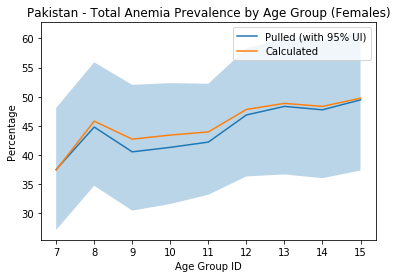

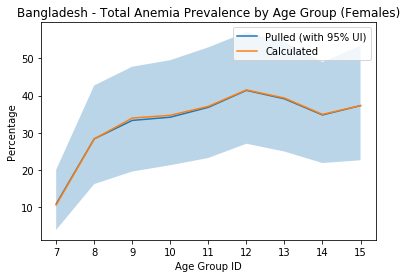

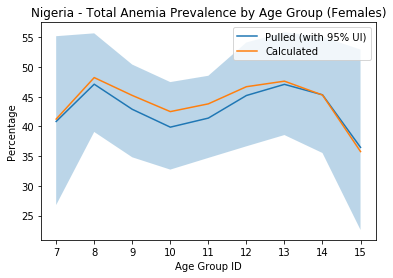

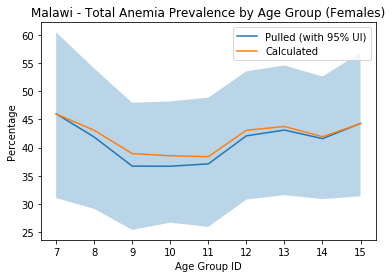

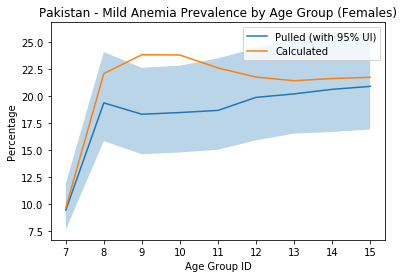

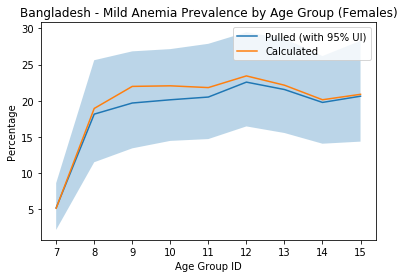

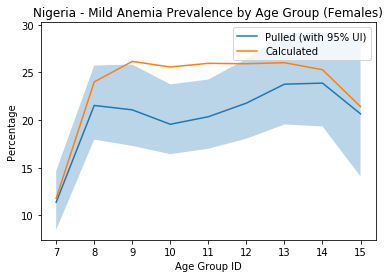

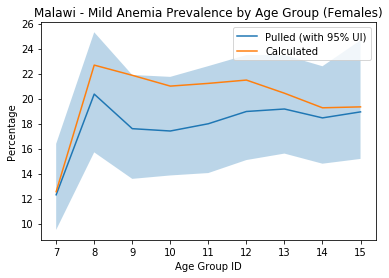

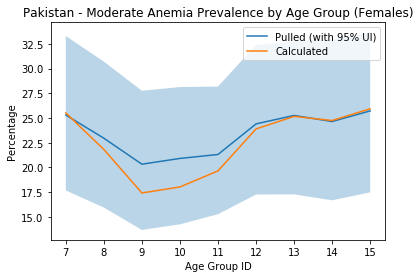

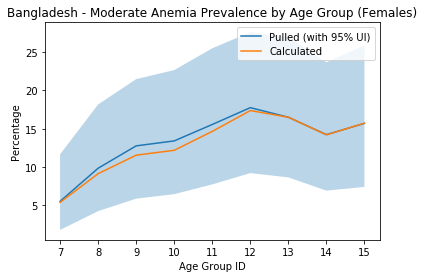

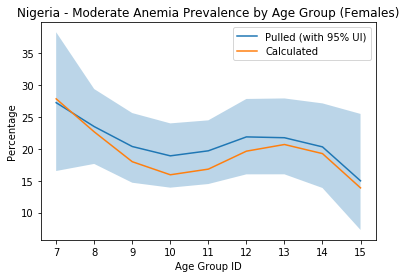

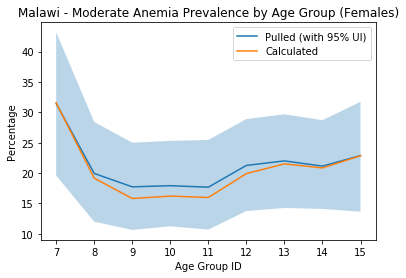

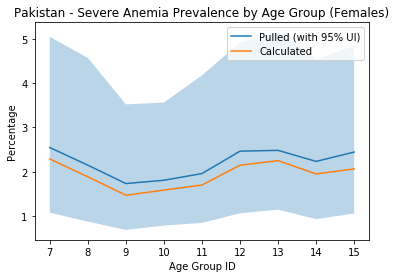

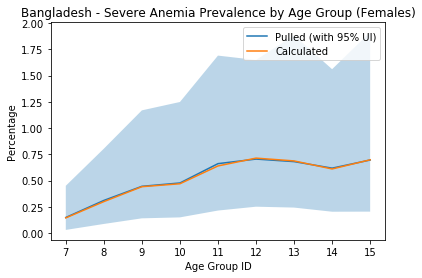

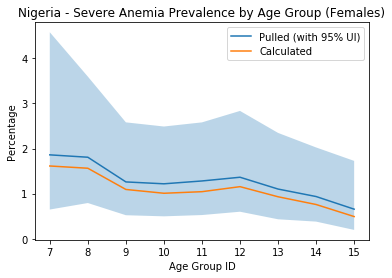

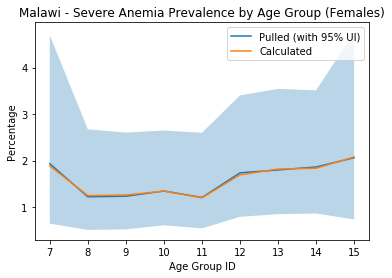

In [41]:
plot_calculated_vs_pulled(locs, ['total','mild','moderate','severe'])

# CONCLUSIONS:

The methodology in this notebook overestimates total and mild anemia prevalence and underestimates moderate and severe anemia prevalence relative to GBD 2019 anemia impairment prevalence, but **is generally within the GBD 95% uncertainty interval**, with a couple exceptions for mild anemia overestimation